In [1]:
import math
import networkx as nx
import graphviz
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import stats

PREPROCESSED = Path('../data/preprocessed')
ASSETS = Path(f'../assets/majestic-1000/communication-examples')
CHART_FILE_EXTENSION = ".svg"

color_cycle = sns.color_palette("Set2")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
resources = pd.read_csv(PREPROCESSED / 'resources.csv')

cols = ['packets', 'sizes', 'ip_src', 'ip_dst', 'rel_time', 'outgoing', 'outgoing_sizes']
for col in cols:
    resources[col] = resources[col].apply(eval)
    
resources.head()

,id,url,connection_id,ip,org,protocol,method,website_call,start,end_header,end_stream,content,type,first_party,context,ip_context,packets,hostname,is_tp,study_name,is_tracker,filter,sizes,ip_src,ip_dst,rel_time,start_time,end_time,delta_req_time,incoming,incoming_sizes,outgoing,outgoing_sizes
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,"Amazon.com, Inc.",http2,GET,mozilla.org,20,26.0,26.0,text/html,document,www.mozilla.org,mozilla.org,13.32.119.185,"[20, 26]",mozilla.org,False,before accept,False,NaN,"[347, 435]","[172.17.0.4, 44.236.72.93]","[44.236.72.93, 172.17.0.4]","[0.404504, 0.595066]",0.404504,0.595066,0.000000,[26],[435],[20],[347]
1,44fb20d146dca8a9e9639f20d087212cda626632bbd00e8b86cd343d,https://mozilla.org/,c7479fa7a53b20525b11f449e9455477fe68593d6c4f0b10fc2c6e21,44.236.72.93,"Amazon.com, Inc.",http2,GET,mozilla.org,20,26.0,26.0,text/html,document,www.mozilla.org,mozilla.org,13.32.119.185,"[20, 26]",mozilla.org,False,accepting policy,False,NaN,"[454, 435]","[172.17.0.4, 44.236.72.93]","[44.236.72.93, 172.17.0.4]","[0.421334, 0.613724]",0.421334,0.613724,0.000000,[26],[435],[20],[454]
2,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,"Amazon.com, Inc.",http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,document,www.mozilla.org,mozilla.org,13.32.119.185,"[51, 59, 61]",mozilla.org,False,before accept,False,NaN,"[351, 1460, 305]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.6612, 0.6762, 0.676207]",0.661200,0.676207,0.000000,"[59, 61]","[1460, 305]",[51],[351]
3,815a3078fff2a4cd95623602374ca6ff1b6cf1628e368dd60e1dc44b,https://www.mozilla.org/en-US/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,"Amazon.com, Inc.",http2,GET,mozilla.org,65,81.0,84.0,text/html; charset=utf-8,document,www.mozilla.org,mozilla.org,13.32.119.185,"[65, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84]",mozilla.org,False,before accept,False,NaN,"[56, 1460, 1460, 1460, 1332, 1428, 1460, 1460, 1460, 1460, 1300, 1460, 1460, 1460, 1332, 1352]","[172.17.0.4, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.677486, 0.693474, 0.693644, 0.693651, 0.693653, 0.693655, 0.693963, 0.693986, 0.693987, 0.693988, 0.693989, 0.694866, 0.694871, 0.694873, 0.694874, 0.694875]",0.677486,0.694875,0.016286,"[67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84]","[1460, 1460, 1460, 1332, 1428, 1460, 1460, 1460, 1460, 1300, 1460, 1460, 1460, 1332, 1352]",[65],[56]
4,5d10a4d49a66e53dc9ab3aa886139668faa92c3ee3bbcba0c059a982,https://www.mozilla.org/media/js/site.7afc1ba3aa92.js,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,"Amazon.com, Inc.",http2,GET,mozilla.org,86,108.0,108.0,application/javascript,script,www.mozilla.org,mozilla.org,13.32.119.185,"[86, 107, 108]",mozilla.org,False,before accept,False,NaN,"[163, 1460, 1240]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.707143, 0.722181, 0.72219]",0.707143,0.722190,0.029657,"[107, 108]","[1460, 1240]",[86],[163]


In [3]:
#df_diff = pd.read_csv('false-positives.csv', index_col=0)
#resources = resources.join(df_diff['prediction'], how='left')

KeyError: 'prediction'

In [ ]:
communications = {}
for name, website_gp in resources.groupby('website_call'):
    fp = website_gp[~website_gp['is_tp']]
    fp = {'hostname': website_gp.iloc[0]['first_party'],
          'rel_time': fp['rel_time'].apply(lambda x: (min(x), max(x))).tolist(),
          'size': fp['sizes'].apply(sum).tolist(),
          'is_tracker': fp['is_tracker'].tolist()
         }
    tps = []
    for hostname, hostname_gp in website_gp[website_gp['is_tp']].groupby('hostname'):
        rel_time = hostname_gp['rel_time'].apply(lambda x: (min(x), max(x))).tolist()
        size = hostname_gp['sizes'].apply(sum).tolist()
        tps.append({'hostname': hostname, 'rel_time': rel_time, 'size': size, 'is_tracker': hostname_gp['is_tracker'].tolist()})
    
    communications[name] = ({'first_party': fp, 'third_parties': tps})

In [ ]:
import matplotlib.colors

def plot_graph(key):
    data = communications[key]
    G = nx.Graph()
    
    G.add_node(data['first_party']['hostname'])
    colors = [sum(data['first_party']['is_tracker']) / len(data['first_party']['is_tracker'])]
    size = [sum(data['first_party']['size'])]
    start_time = [np.asarray(data['first_party']['rel_time']).min()]
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", color_cycle[:2])
    
    for tp in data['third_parties']:
        G.add_edge(tp['hostname'], data['first_party']['hostname'])
        colors.append(sum(tp['is_tracker']) / len(tp['is_tracker']))
        size.append(sum(tp['size']))
        start_time.append(np.asarray(tp['rel_time']).min())

    size = [(s - min(size)) / (max(size) - min(size)) for s in size]
    size = [s*2200 + 50 for s in size]
    start_time = [(t - min(start_time)) / (max(start_time) - min(start_time)) for t in start_time]
    start_time = [t*2 + .5 for t in start_time]
    
    plt.figure(figsize=(9,9))
    nx.draw(G, with_labels=True, node_color=colors, font_size=8, node_size=size, width=start_time, cmap=cmap)
    ax=plt.gca()
    PCM=ax.get_children()[0] # this index may vary
    plt.colorbar(PCM, ax=ax, shrink=0.75)
    plt.savefig(ASSETS / f'{key}-tree{CHART_FILE_EXTENSION}', bbox_inches="tight")
    

In [ ]:
plot_graph('nytimes.com')

In [ ]:
plot_graph('statista.com')

In [ ]:
plot_graph('britannica.com')

In [8]:
packets = resources.explode(["packets", "sizes", "ip_src", "ip_dst", "rel_time"])
packets = packets.rename(columns={'packets': 'packet', 'sizes': 'size'})
packets['is_outgoing'] = packets['ip_src'].apply(lambda x: x.startswith('172.17'))
packets['directed_size'] = packets.apply(lambda row: -row['size'] if row['is_outgoing'] else row['size'], axis=1)
packets.head()

,id,url,connection_id,ip,org,protocol,method,website_call,start,end_header,end_stream,content,type,first_party,context,ip_context,packet,hostname,is_tp,study_name,is_tracker,filter,size,ip_src,ip_dst,rel_time,start_time,end_time,delta_req_time,incoming,incoming_sizes,outgoing,outgoing_sizes,is_outgoing,directed_size
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,"Amazon.com, Inc.",http2,GET,mozilla.org,20,26.0,26.0,text/html,document,www.mozilla.org,mozilla.org,13.32.119.185,20,mozilla.org,False,before accept,False,NaN,347,172.17.0.4,44.236.72.93,0.404504,0.404504,0.595066,0.0,[26],[435],[20],[347],True,-347
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,"Amazon.com, Inc.",http2,GET,mozilla.org,20,26.0,26.0,text/html,document,www.mozilla.org,mozilla.org,13.32.119.185,26,mozilla.org,False,before accept,False,NaN,435,44.236.72.93,172.17.0.4,0.595066,0.404504,0.595066,0.0,[26],[435],[20],[347],False,435
1,44fb20d146dca8a9e9639f20d087212cda626632bbd00e8b86cd343d,https://mozilla.org/,c7479fa7a53b20525b11f449e9455477fe68593d6c4f0b10fc2c6e21,44.236.72.93,"Amazon.com, Inc.",http2,GET,mozilla.org,20,26.0,26.0,text/html,document,www.mozilla.org,mozilla.org,13.32.119.185,20,mozilla.org,False,accepting policy,False,NaN,454,172.17.0.4,44.236.72.93,0.421334,0.421334,0.613724,0.0,[26],[435],[20],[454],True,-454
1,44fb20d146dca8a9e9639f20d087212cda626632bbd00e8b86cd343d,https://mozilla.org/,c7479fa7a53b20525b11f449e9455477fe68593d6c4f0b10fc2c6e21,44.236.72.93,"Amazon.com, Inc.",http2,GET,mozilla.org,20,26.0,26.0,text/html,document,www.mozilla.org,mozilla.org,13.32.119.185,26,mozilla.org,False,accepting policy,False,NaN,435,44.236.72.93,172.17.0.4,0.613724,0.421334,0.613724,0.0,[26],[435],[20],[454],False,435
2,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,"Amazon.com, Inc.",http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,document,www.mozilla.org,mozilla.org,13.32.119.185,51,mozilla.org,False,before accept,False,NaN,351,172.17.0.4,13.32.119.185,0.6612,0.661200,0.676207,0.0,"[59, 61]","[1460, 305]",[51],[351],True,-351


In [10]:
packet_flow = packets.groupby(['study_name', 'website_call', 'hostname']).agg({'rel_time': list, 'directed_size': list, 'size': list, 'is_outgoing': list, 'is_tracker': list})

In [15]:
def plot_traffic_flow(study_name, website):
    length = min(24, len(packet_flow.loc[(study_name, website)]))
    fig_height = math.ceil(length / 3)*1.5
    fig, axs2d = plt.subplots(math.ceil(length / 3), 3, figsize=(12,fig_height), sharex=True, sharey=True)
    if not isinstance(axs2d[0], np.ndarray):
        axs2d = [axs2d]
    
    iterator = iter(packet_flow.loc[(study_name, website)].index)
    axs2d[0][0].scatter([],[], color=color_cycle[0], label='Non-Tracker')
    axs2d[0][0].scatter([],[], color=color_cycle[1], label='Tracker')

    for row, ax1d in enumerate(axs2d):
        for col, ax in enumerate(ax1d):
            if row == 0 and col == 0:
                host = website
            else:
                try:
                    while True:
                        host = next(iterator)
                        if host != website:
                            break
                except:
                    axs2d[row,col].set_axis_off()
                    break
                    
            data = packet_flow.loc[(study_name, website, host)]
            color = [color_cycle[1] if is_tracker else color_cycle[0] for is_tracker in data['is_tracker']]
            ax.scatter(data['rel_time'], data['directed_size'], s=12, marker='x', color=color, label=data['is_tracker'])
            color = color_cycle[4] if host == website else 'k'
            ax.set_title(host, color=color)
            ax.xaxis.set_tick_params(labelbottom=True)
            ax.yaxis.set_tick_params(labelleft=True)
            ax.axhline(y=0, color='k', linewidth=.5)
            if row == len(axs2d) - 1:
                ax.set_xlabel("Time [s]")
            if col == 0:
                ax.set_ylabel("Flow [bytes]")

    fig.tight_layout()
    # fancybox=True, shadow=True
    fig.legend(['Non-Tracker', 'Tracker'], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=2)
    fig.savefig(ASSETS / f'{website}-traffic-flow-{study_name}{CHART_FILE_EXTENSION}', bbox_inches="tight")

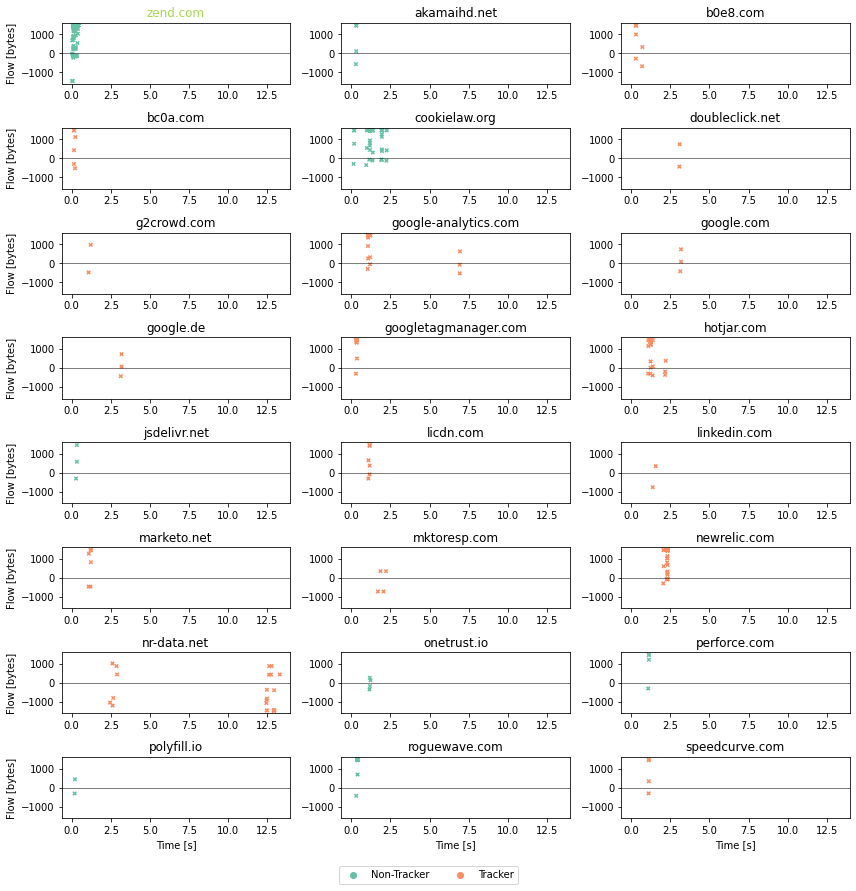

In [11]:
# good service entropy
plot_traffic_flow('after accept', 'zend.com')

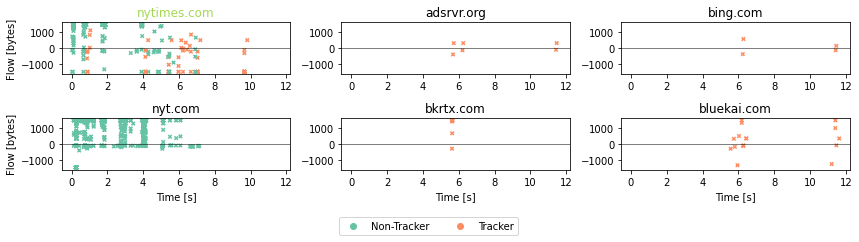

In [14]:
plot_traffic_flow('after accept', 'nytimes.com')

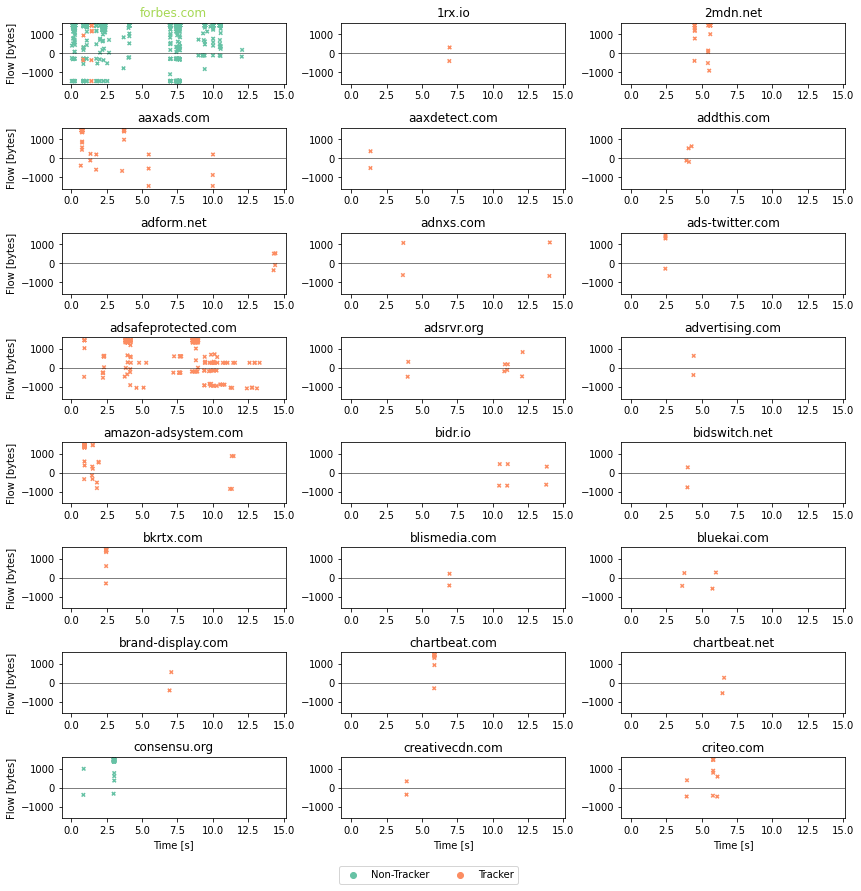

In [13]:
plot_traffic_flow('after accept', 'forbes.com')

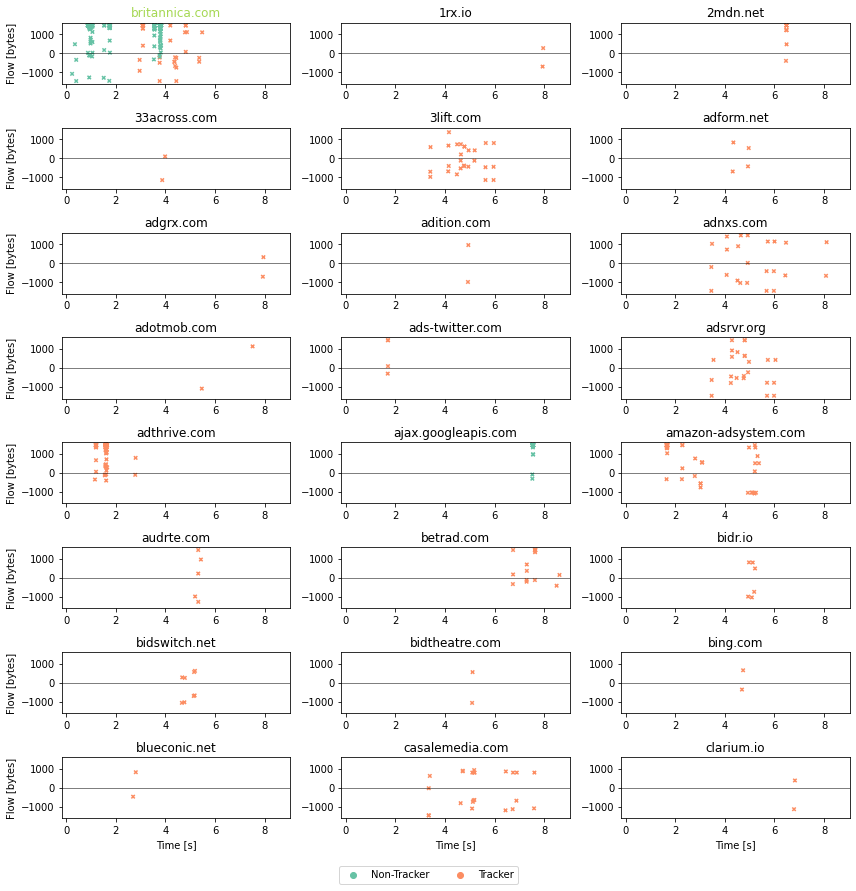

In [14]:
plot_traffic_flow('after accept', 'britannica.com')

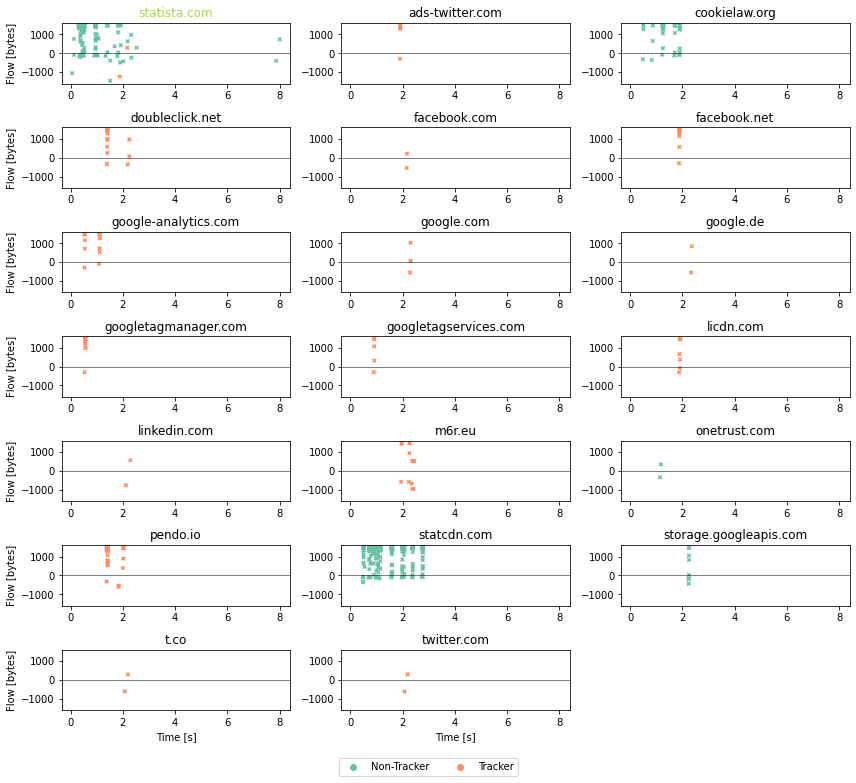

In [15]:
plot_traffic_flow('after accept', 'statista.com')

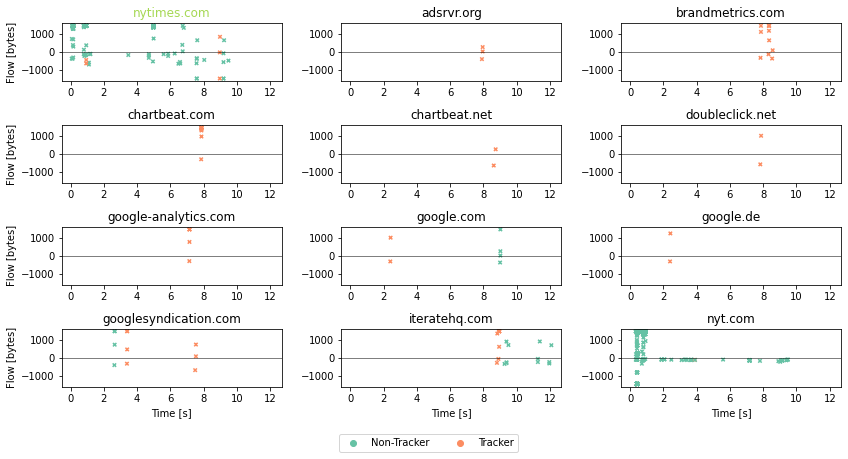

In [16]:
plot_traffic_flow('before accept', 'nytimes.com')

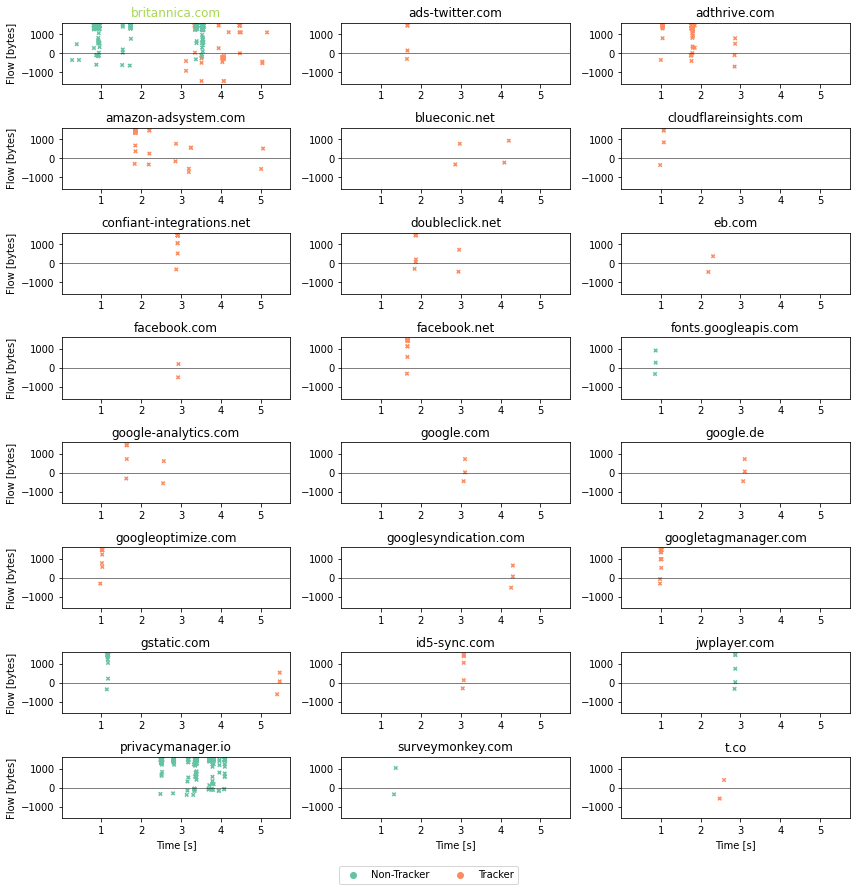

In [17]:
plot_traffic_flow('before accept', 'britannica.com')

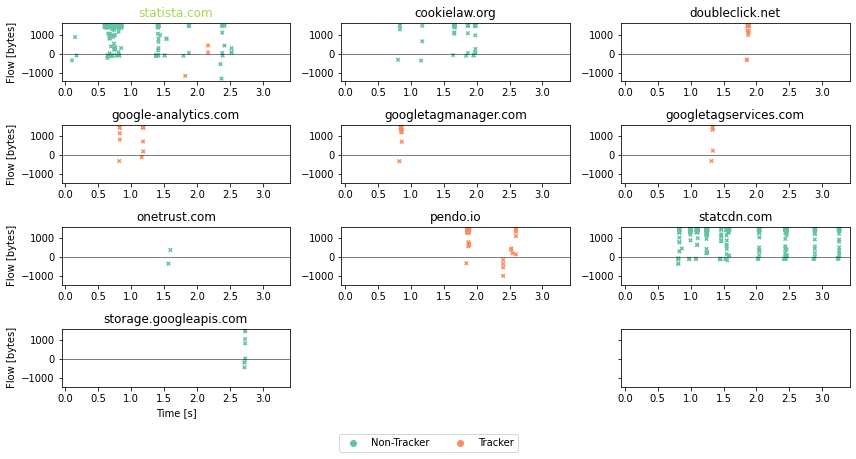

In [18]:
plot_traffic_flow('before accept', 'statista.com')

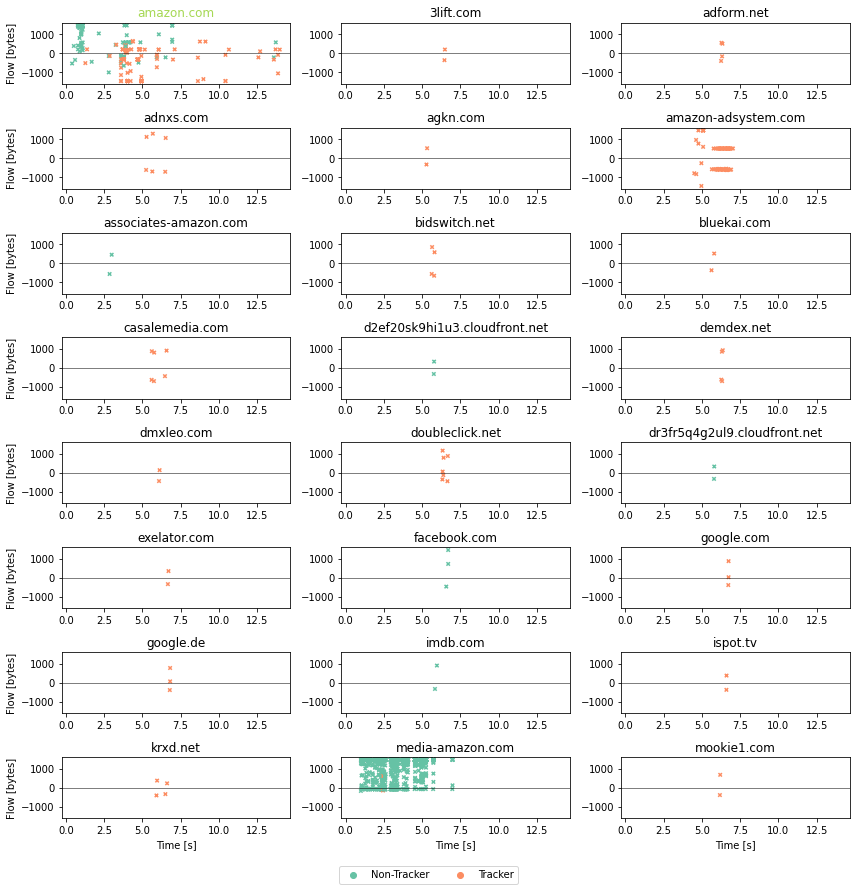

In [19]:
# good service entropy
plot_traffic_flow('before accept', 'amazon.com')

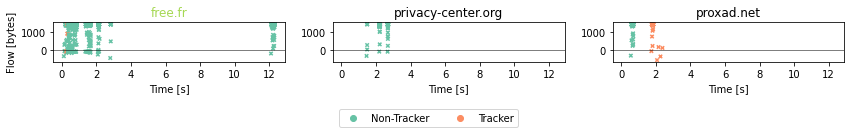

In [20]:
# bad service entropy
plot_traffic_flow('before accept', 'free.fr')

## Pearson Correlation

In [21]:
packet_flow['tracking_ratio'] = packet_flow['is_tracker'].apply(lambda x: sum(x) / len(x))
packet_flow['len'] = packet_flow['is_tracker'].apply(len)
stats.pearsonr(packet_flow['len'], packet_flow['tracking_ratio'])

(-0.29457773695234923, 0.0)

Pearson correlation between tracking ratio and number of packets (in a communiation link to a party) is negativ, meaning a higher packet volume (more packets) the less tracking.

In [22]:
resources[(~resources['is_tp']) & (resources['website_call'] == 'nytimes.com') & (resources['study_name'] == 'after accept') & (~resources['is_tracker'])][['url', 'hostname', 'ip', 'method', 'start_time', 'end_time', 'is_tracker']]

,url,hostname,ip,method,start_time,end_time,is_tracker
228289,https://nytimes.com/,nytimes.com,151.101.1.164,GET,0.032187,0.042255,False
228456,https://www.nytimes.com/,nytimes.com,151.101.113.164,GET,0.078698,0.116470,False
228457,https://www.nytimes.com/vi-assets/static-assets/global-f449cfd9976ad673ef2b7ab5098b85be.css,nytimes.com,151.101.113.164,GET,0.115167,0.123932,False
228536,https://samizdat-graphql.nytimes.com/graphql/v2,nytimes.com,151.101.113.164,OPTIONS,0.650062,0.657975,False
228537,https://samizdat-graphql.nytimes.com/graphql/v2,nytimes.com,151.101.113.164,POST,0.661217,0.669292,False
228539,https://www.nytimes.com/vi-assets/static-assets/adslot-163eed3eb592753ba35a.js,nytimes.com,151.101.113.164,GET,0.681840,0.691021,False
228540,https://static01.nytimes.com/newsgraphics/2022-11-04-election-opinion-hp-module/f7a1918f9d28375385381781cd3ab80eedc4f8b6/_assets/embed.css,nytimes.com,151.101.113.164,GET,0.683554,0.691190,False
228541,https://static01.nytimes.com/newsgraphics/2022-11-04-election-opinion-hp-module/f7a1918f9d28375385381781cd3ab80eedc4f8b6/_assets/build/css/components.css,nytimes.com,151.101.113.164,GET,0.683617,0.691255,False
228551,https://static01.nytimes.com/newsgraphics/storylines/styln-hp-reporteranalysis/a979579c5c9e5f7fe99d8b0720388a39db7dceff/LiveHPPromo.js,nytimes.com,151.101.113.164,GET,0.755791,0.782645,False
228552,https://static01.nytimes.com/newsgraphics/ec6a7e86184c96adcd2ce7517838fe9d980efa6c/static/js/styln-carousel.js,nytimes.com,151.101.113.164,GET,0.756809,0.805782,False


In [23]:
resources[(~resources['is_tp']) & (resources['website_call'] == 'nytimes.com') & (resources['study_name'] == 'after accept') & (resources['is_tracker'])][['url', 'hostname', 'ip', 'method', 'start_time', 'end_time', 'is_tracker']]

,url,hostname,ip,method,start_time,end_time,is_tracker
228938,https://a-reporting.nytimes.com/report.jpg?mobile=false&block=false&aid=UYnxXkgHY-nGXqGasS7O1s&pvid=FnPaqslaH6IMxIDosFRNjPv-&et=true,nytimes.com,35.244.227.0,GET,6.662159,6.673677,True
228940,https://a.et.nytimes.com/track,nytimes.com,52.54.49.121,POST,0.868187,1.020114,True
228941,https://als-svc.nytimes.com/als?uri=https%3A%2F%2Fwww.nytimes.com%2Fpages%2Findex.html&typ=&prop=nyt&plat=web,nytimes.com,52.54.49.121,GET,0.908020,1.050380,True
228942,https://a.et.nytimes.com/track,nytimes.com,52.54.49.121,POST,4.124746,4.280553,True
228946,https://a.et.nytimes.com/track,nytimes.com,52.54.49.121,POST,5.428715,5.590507,True
228947,https://a.et.nytimes.com/track,nytimes.com,52.54.49.121,POST,5.976475,6.130961,True
228948,https://a.et.nytimes.com/track,nytimes.com,52.54.49.121,POST,6.224100,6.378927,True
228949,https://a.et.nytimes.com//.status,nytimes.com,52.54.49.121,GET,6.451614,6.605670,True
228950,https://a.et.nytimes.com/track,nytimes.com,52.54.49.121,POST,7.036290,7.194412,True
228951,https://a.et.nytimes.com/track,nytimes.com,52.54.49.121,POST,9.649794,9.812102,True


In [24]:
resources[(~resources['is_tp']) & (resources['website_call'] == 'nytimes.com') & (resources['study_name'] == 'after accept')]['ip'].unique()

array(['151.101.1.164', '151.101.113.164', '35.244.227.0', '52.54.49.121',
       '52.222.236.25'], dtype=object)

In [72]:
def plot_traffic_flow_fp(study_name, website):
    length = min(24, len(packet_flow.loc[(study_name, website)]))
    fig_height = math.ceil(length / 3)*1.5
    fig, axs2d = plt.subplots(math.ceil(length / 3), 3, figsize=(12,fig_height), sharex=True, sharey=True)
    if not isinstance(axs2d[0], np.ndarray):
        axs2d = [axs2d]
    
    iterator = iter(packet_flow.loc[(study_name, website)].index)
    axs2d[0][0].scatter([],[], color=color_cycle[0], label='Non-Tracker')
    axs2d[0][0].scatter([],[], color=color_cycle[1], label='Tracker')

    for row, ax1d in enumerate(axs2d):
        for col, ax in enumerate(ax1d):
            if row == 0 and col == 0:
                host = website
            else:
                try:
                    while True:
                        host = next(iterator)
                        if host != website:
                            break
                except:
                    axs2d[row,col].set_axis_off()
                    break
                    
            data = packet_flow.loc[(study_name, website, host)]
            color = [color_cycle[1] if is_tracker else color_cycle[0] for is_tracker in data['is_tracker']]
            stroke = ['r' if tr != pr else 'none' for tr, pr in zip(data['is_tracker'], data['prediction'])]
            ax.scatter(data['rel_time'], data['directed_size'], s=12, marker='o', color=color, label=data['is_tracker'], edgecolors=stroke, linewidths=.3)
            color = color_cycle[4] if host == website else 'k'
            ax.set_title(host, color=color)
            ax.xaxis.set_tick_params(labelbottom=True)
            ax.yaxis.set_tick_params(labelleft=True)
            ax.axhline(y=0, color='k', linewidth=.5)
            if row == len(axs2d) - 1:
                ax.set_xlabel("Time [s]")
            if col == 0:
                ax.set_ylabel("Flow [bytes]")

    fig.tight_layout()
    # fancybox=True, shadow=True
    fig.legend(['Non-Tracker', 'Tracker'], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=2)
    fig.savefig(ASSETS / f'{website}-traffic-flow-{study_name}-false{CHART_FILE_EXTENSION}', bbox_inches="tight")

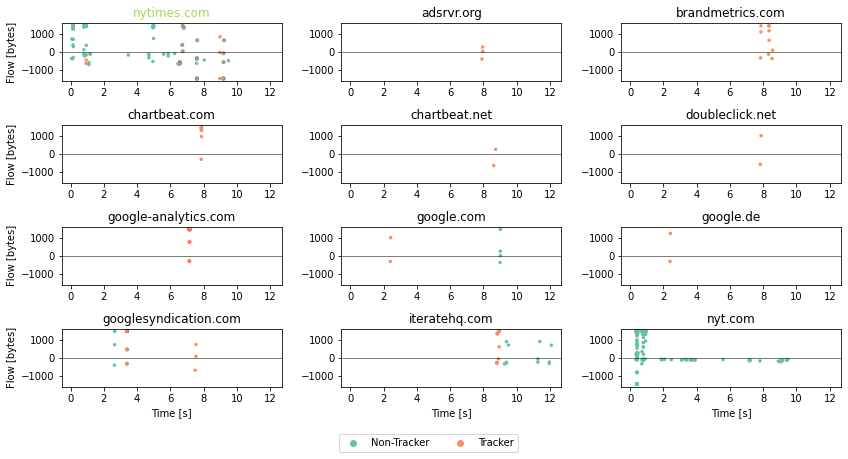

In [73]:
plot_traffic_flow_fp('before accept', 'nytimes.com')

In [75]:
resources.query("website_call == 'nytimes.com' & study_name == 'before accept' & hostname == 'nytimes.com' & start_time > 6")

,id,url,connection_id,ip,org,protocol,method,website_call,start,end_header,end_stream,content,type,first_party,context,ip_context,packets,hostname,is_tp,study_name,is_tracker,filter,sizes,ip_src,ip_dst,rel_time,start_time,end_time,delta_req_time,incoming,incoming_sizes,outgoing,outgoing_sizes,prediction
152644,40a5d2d01ecbc8c342ccc3a3089a4be81073f609d745045e59364c3c,https://dd.nytimes.com/js/,f33a157ee36662290401f6dae7a2a00afc81e46884799b6fbec9ce6c,52.222.236.49,"Amazon.com, Inc.",http2,POST,nytimes.com,6085,6098.0,6098.0,application/json;charset=utf-8,other,www.nytimes.com,nytimes.com,151.101.113.164,"[6085, 6086, 6087, 6089, 6098]",nytimes.com,False,before accept,False,NaN,"[334, 1460, 1460, 373, 660]","[172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 52.222.236.49]","[52.222.236.49, 52.222.236.49, 52.222.236.49, 52.222.236.49, 172.17.0.2]","[7.581379, 7.581702, 7.581704, 7.581833, 7.609289]",7.581379,7.609289,2.634392,[6098],[660],"[6085, 6086, 6087, 6089]","[334, 1460, 1460, 373]",True
152645,26850bfc853a928e206eb32d64b1cf816b85a1bdecbb16c1654d7c5e,https://dd.nytimes.com/js/,f33a157ee36662290401f6dae7a2a00afc81e46884799b6fbec9ce6c,52.222.236.49,"Amazon.com, Inc.",http2,POST,nytimes.com,6791,6797.0,6797.0,application/json;charset=utf-8,other,www.nytimes.com,nytimes.com,151.101.113.164,"[6791, 6792, 6793, 6794, 6797]",nytimes.com,False,before accept,False,NaN,"[62, 1460, 1460, 551, 660]","[172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 52.222.236.49]","[52.222.236.49, 52.222.236.49, 52.222.236.49, 52.222.236.49, 172.17.0.2]","[9.184973, 9.185113, 9.185114, 9.18515, 9.220906]",9.184973,9.220906,1.603594,[6797],[660],"[6791, 6792, 6793, 6794]","[62, 1460, 1460, 551]",True
228428,86e1f099948ac66a4811764c12c1b32b587f94a2cad2b0b371ac78c5,https://www.nytimes.com/api/market,aa42a72eddb347b115b50564342e477fe65a988bc015e86b71e34187,151.101.113.164,"Fastly, Inc.",http2,GET,nytimes.com,5597,NaN,NaN,NaN,NaN,www.nytimes.com,nytimes.com,151.101.113.164,[5597],nytimes.com,False,before accept,False,NaN,[74],[172.17.0.2],[151.101.113.164],[6.254449],6.254449,6.254449,0.394977,[],[],[5597],[74],False
228441,ed651cfc4814cbdf83825ceb2c68fcf252023db6943f17fd20e03920,https://www.nytimes.com/svc/int/functions/geoip,aa42a72eddb347b115b50564342e477fe65a988bc015e86b71e34187,151.101.113.164,"Fastly, Inc.",http2,GET,nytimes.com,6067,NaN,NaN,NaN,NaN,www.nytimes.com,nytimes.com,151.101.113.164,[6067],nytimes.com,False,before accept,False,NaN,[615],[172.17.0.2],[151.101.113.164],[7.568091],7.568091,7.568091,0.385097,[],[],[6067],[615],False
228443,ae14160af159a44165bbd06373be99d72511052a966da30bef13686c,https://mwcm.nytimes.com/capi/metered_assets/?plat=web&mc=0&mr=1&ma=1&counted=false&granted=true&us=anon&context-type=&areas=barOne&areas=welcomeAd,aa42a72eddb347b115b50564342e477fe65a988bc015e86b71e34187,151.101.113.164,"Fastly, Inc.",http2,GET,nytimes.com,6269,NaN,NaN,NaN,NaN,www.nytimes.com,nytimes.com,151.101.113.164,[6269],nytimes.com,False,before accept,False,NaN,[430],[172.17.0.2],[151.101.113.164],[8.030287],8.030287,8.030287,0.226046,[],[],[6269],[430],False
228455,9d4e64d8197399f9059d9d75f243af2f4d98dab0cfbe0d3e13581daf,https://static01.nytimes.com/newsgraphics/2020/12/09/vaccine-distribution-tracker/assets/scoop-vaccine-distribution-tracker-threeByTwoSmallAt2X.png,aa42a72eddb347b115b50564342e477fe65a988bc015e86b71e34187,151.101.113.164,"Fastly, Inc.",http2,GET,nytimes.com,6896,NaN,NaN,NaN,NaN,www.nytimes.com,nytimes.com,151.101.113.164,[6896],nytimes.com,False,before accept,False,NaN,[469],[172.17.0.2],[151.101.113.164],[9.484363],9.484363,9.484363,0.000208,[],[],[6896],[469],False
228923,661a7104c07766b421e2e652bfce72502581723cad46c9154339bcc6,https://purr.nytimes.com/v1/purr-cache,296356dc6512ab349250f5f996c9d85e35a6d1dc537d6913b36e0a1b,44.211.112.71,Amazon Data Services NoVa,http2,GET,nytimes.com,5651,5679.0,NaN,text/html,document,www.nytimes.com,nytimes.com,151.101.113.164,"[5651, 5679]",nytimes.com,False,before accept,False,NaN,"[543, 404]